In [1]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #
import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp


beta_rel = 0.305
#beta_rel = 0.106

gamma = 1.050
#gamma = 1.006

current=2.4
cooler_length = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 100e-3 # <E> [eV] = kb*T
T_l =  1e-3 # <E> [eV]
magnetic_field = 0.060 # T for AD
B_ratio=1e-10
Z=1

c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c

circumference = 182.43280000000 #m
T = circumference/(c*beta_rel)
s_per_turn = T

beta_x=10 
beta_y=4

#disp_x=0.12
#disp_x=0
dx=0


import xobjects as xo
context = xo.ContextCpu()

num_particles=1
emitt_x=1*1e-6 #inital emittance

x_init=np.sqrt(beta_x*emitt_x)
px_init=np.sqrt(1/beta_x*emitt_x)
y_init=np.sqrt(beta_y*emitt_x)
py_init=np.sqrt(1/beta_y*emitt_x)
delta_init=5e-4

# Generate the normal distributions
# x_init = np.random.normal(loc=0, scale=x_init, size=num_particles)
# px_init = np.random.normal(loc=0, scale=px_init, size=num_particles)
# y_init = np.random.normal(loc=0, scale=y_init, size=num_particles)
# py_init = np.random.normal(loc=0, scale=py_init, size=num_particles)
#delta_init = np.random.normal(loc=0, scale=delta_init, size=num_particles)

In [2]:
particles = xp.Particles(
        
        mass0=mass0,
        p0c=p0c,
        q0=Z,
        x=x_init,
        px=px_init,
        y=y_init,
        py=py_init,
        delta=delta_init,
        zeta=0)

particle_ref=xp.Particles(mass0=mass0, q0=Z, p0c=p0c)

cooler_xs = xt.ElectronCooler(current=current,length=cooler_length,radius_e_beam=r_beam,
                                temp_perp=T_perp,temp_long=T_l,
                                magnetic_field=magnetic_field,magnetic_field_ratio=B_ratio,
                                space_charge=1,
                                offset_energy=10)

# line.build_tracker(_context=context)

num_turns=int(1*1e6)

step=1


save_interval = 1

# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                        n_repetitions=int(num_turns/save_interval),
                        repetition_period=save_interval,
                        num_particles=1)

line = xt.Line(elements=[monitor, cooler_xs],element_names=['monitor','electron_cooler'])
line.particle_ref=particle_ref
line.build_tracker(_context=context)




Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [3]:
line.track(particles, num_turns=num_turns,
                        turn_by_turn_monitor=False,with_progress=True)


# extract relevant values
x_xs = monitor.x[:,:,0]
px_xs = monitor.px[:,:,0]
y_xs = monitor.y[:,:,0]
py_xs = monitor.py[:,:,0]
delta_xs = monitor.delta[:,:,0]
zeta_xs = monitor.zeta[:,:,0]
#time_xs = monitor.at_turn[:, 0, 0] * T_per_turn

# compute actions. for x, remove the dp/p contribution:
action_x = ((x_xs-dx*delta_xs)**2/beta_x + beta_x*px_xs**2)
# for y, simple compute:
action_y = (y_xs**2/beta_y + beta_y*py_xs**2)
emittance_x=np.mean(action_x, axis=1)/2
# norm_emittance_x=np.mean(action_x,axis=1)/2*gamma0*beta0
# norm_emittance_y=np.mean(action_y,axis=1)/2*gamma0*beta0

geo_emittance_x=np.mean(action_x,axis=1)/2
geo_emittance_y=np.mean(action_y,axis=1)/2

Tracking:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [4]:
import ducktrack as dtk
dtk_particle = dtk.TestParticles(
        
        mass0=mass0,
        p0c=p0c,
        x=x_init,
        px=px_init,
        y=y_init,
        py=py_init,
        delta=delta_init,
        zeta=0)

dtk_cooler = dtk.elements.ElectronCooler(current=current,length=cooler_length,radius_e_beam=r_beam,
                                temp_perp=T_perp,temp_long=T_l,
                                magnetic_field=magnetic_field,magnetic_field_ratio=B_ratio,
                                space_charge_factor=1,
                                offset_energy=10)
# initialize arrays
x = []
px = []
action_x = []
action_y = []
py = []
delta = []

for i in tqdm(range(num_turns)):
    
    x.append(dtk_particle.x)
    px.append(dtk_particle.px) 
    py.append(dtk_particle.py)
    delta.append(dtk_particle.delta)

    # calculate action in horizontal plane
    action_x_temp = (dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2)
    action_x.append(action_x_temp)
    action_y_temp = (dtk_particle.y**2/beta_y + beta_y*dtk_particle.py**2)
    action_y.append(action_y_temp)

    #arc.track(dtk_particle)
    dtk_cooler.track(dtk_particle)

# convert arrays to numpy arrays
x = np.array(x)
px = np.array(px)
action_x = np.array(action_x)

time = np.arange(0, num_turns, step) * s_per_turn


100%|██████████| 1000000/1000000 [01:55<00:00, 8630.94it/s]


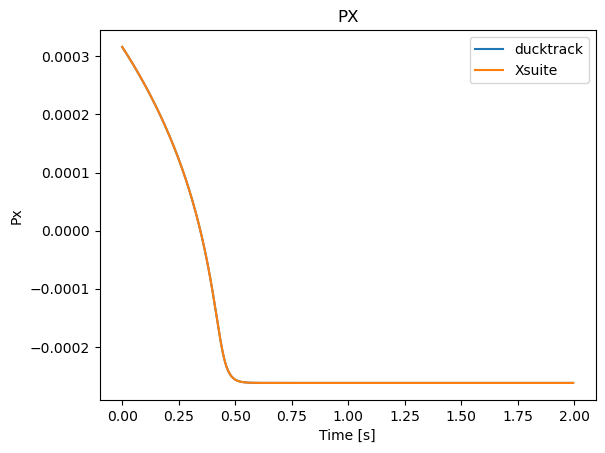

In [5]:
# Plot the horizontal action versus time
plt.figure()

plt.plot(time,px,label='ducktrack')
plt.plot(time,px_xs.flatten(),label='Xsuite')

plt.xlabel('Time [s]')
plt.ylabel('Px')
plt.title('PX')
plt.legend()
plt.ticklabel_format(useOffset=False)

In [6]:
particles.beta0

LinkedArrayCpu([0.30499169])

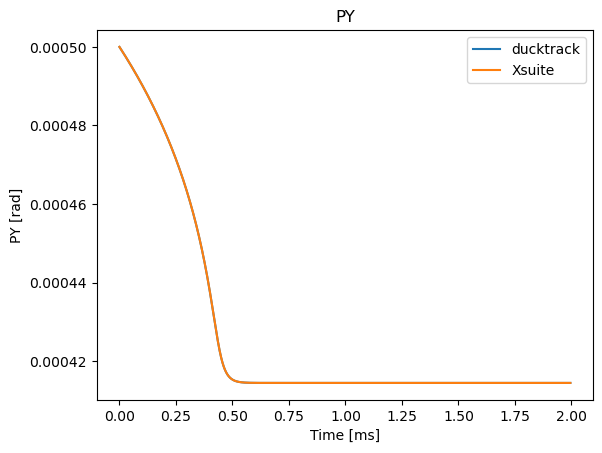

In [7]:
# Plot the horizontal action versus time
plt.figure()

plt.plot(time,py,label='ducktrack')
plt.plot(time,py_xs,label='Xsuite')

plt.xlabel('Time [ms]')
plt.ylabel('PY [rad]')
plt.title('PY')
plt.legend()
plt.ticklabel_format(useOffset=False)

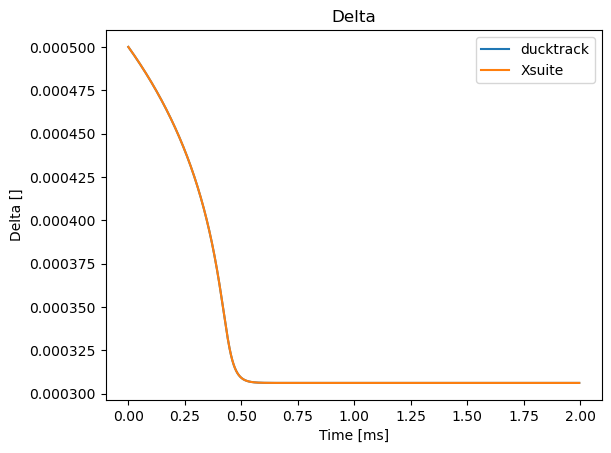

In [8]:
# Plot the horizontal action versus time
plt.figure()

plt.plot(time,delta,label='ducktrack')
plt.plot(time,delta_xs,label='Xsuite')

plt.xlabel('Time [ms]')
plt.ylabel('Delta []')
plt.title('Delta')
plt.legend()
plt.ticklabel_format(useOffset=False)

In [9]:
# import xobjects as xo
# test_context=xo.ContextCpu()

# assert np.isclose(test_context.nparray_from_context_array(particles.x)[0],
#                     dtk_particle.x, rtol=1e-14, atol=1e-14)
# assert np.isclose(test_context.nparray_from_context_array(particles.px)[0],
#                     dtk_particle.px, rtol=1e-14, atol=1e-14)
# assert np.isclose(test_context.nparray_from_context_array(particles.y)[0],
#                     dtk_particle.y, rtol=1e-14, atol=1e-14)
# assert np.isclose(test_context.nparray_from_context_array(particles.py)[0],
#                     dtk_particle.py, rtol=1e-14, atol=1e-14)
# assert np.isclose(test_context.nparray_from_context_array(particles.zeta)[0],
#                     dtk_particle.zeta, rtol=1e-14, atol=1e-14)
# assert np.isclose(test_context.nparray_from_context_array(particles.delta)[0],
#                     dtk_particle.delta, rtol=1e-14, atol=1e-14)

In [10]:
# dtk_particle = dtk.TestParticles(
#         mass0=mass0,
#         p0c=p0c,
#         x=x_init,
#         px=px_init,
#         y=y_init,
#         py=py_init,
#         delta=delta_init,
#         zeta=0)



# particles = xp.Particles.from_dict(dtk_particle.to_dict(),
#                                     _context=test_context)
# I=2.4
# L = 1.5 # m cooler length
# r_beam=25*1e-3

# T_perp = 0.01 # <E> [eV] = kb*T
# T_l =  0.001 # <E> [eV]
# B = 0.060 # T for AD
# B_ratio=1e-3
# Z=0
# electron_cooler=xt.ElectronCooler(current=current,length=cooler_length,r_beam=r_beam,
#                                                 T_perp=T_perp,T_l=T_l,
#                                                 magnetic_field=magnetic_field,B_ratio=B_ratio,
#                                                 Neutralisation_space_charge=1,Neutralisation_rotation=1)

# electron_cooler.track(particles)

# dtk_electron_cooler = dtk.elements.ElectronCooler(current=current,length=cooler_length,r_beam=r_beam,
#                                                 T_perp=T_perp,T_l=T_l,
#                                                 magnetic_field=magnetic_field,B_ratio=B_ratio,
#                                                 Neutralisation_space_charge=1,Neutralisation_rotation=1)

# dtk_electron_cooler.track(dtk_particle)


# print(dtk_particle.px)
# print(particles.px[0])


# assert np.isclose(test_context.nparray_from_context_array(particles.x)[0],
#                     dtk_particle.x, rtol=1e-14, atol=1e-14)
# assert np.isclose(test_context.nparray_from_context_array(particles.px)[0],
#                     dtk_particle.px, rtol=1e-14, atol=1e-14)
# assert np.isclose(test_context.nparray_from_context_array(particles.y)[0],
#                     dtk_particle.y, rtol=1e-14, atol=1e-14)
# assert np.isclose(test_context.nparray_from_context_array(particles.py)[0],
#                     dtk_particle.py, rtol=1e-14, atol=1e-14)
# assert np.isclose(test_context.nparray_from_context_array(particles.zeta)[0],
#                     dtk_particle.zeta, rtol=1e-14, atol=1e-14)
# assert np.isclose(test_context.nparray_from_context_array(particles.delta)[0],
#                     dtk_particle.delta, rtol=1e-14, atol=1e-14)


